  INSPECTION_TYPE JOB_TICKET_OR_WORK_ORDER_ID  BORO_CODE  \
0         Initial                    11670593        2.0   
1         Initial                    11758853        1.0   
2         Initial                    12504178        3.0   
3         Initial                    12560587        1.0   
4         Initial                    12345229        2.0   

          INSPECTION_DATE        RESULT  
0  08/30/2010 03:23:11 PM        Passed  
1  08/18/2011 12:05:54 PM        Passed  
2  10/10/2018 12:57:02 PM        Passed  
3  02/07/2019 12:48:34 PM        Passed  
4  10/16/2017 01:02:51 PM  Rat Activity  
✅ After cleaning, 2730179 rows remain.

Confusion Matrix:
[[656586  23733]
 [108241  30494]]

Classification Report:
                 precision    recall  f1-score   support

No Rodent Issue       0.86      0.97      0.91    680319
   Rodent Issue       0.56      0.22      0.32    138735

       accuracy                           0.84    819054
      macro avg       0.71      0.59    

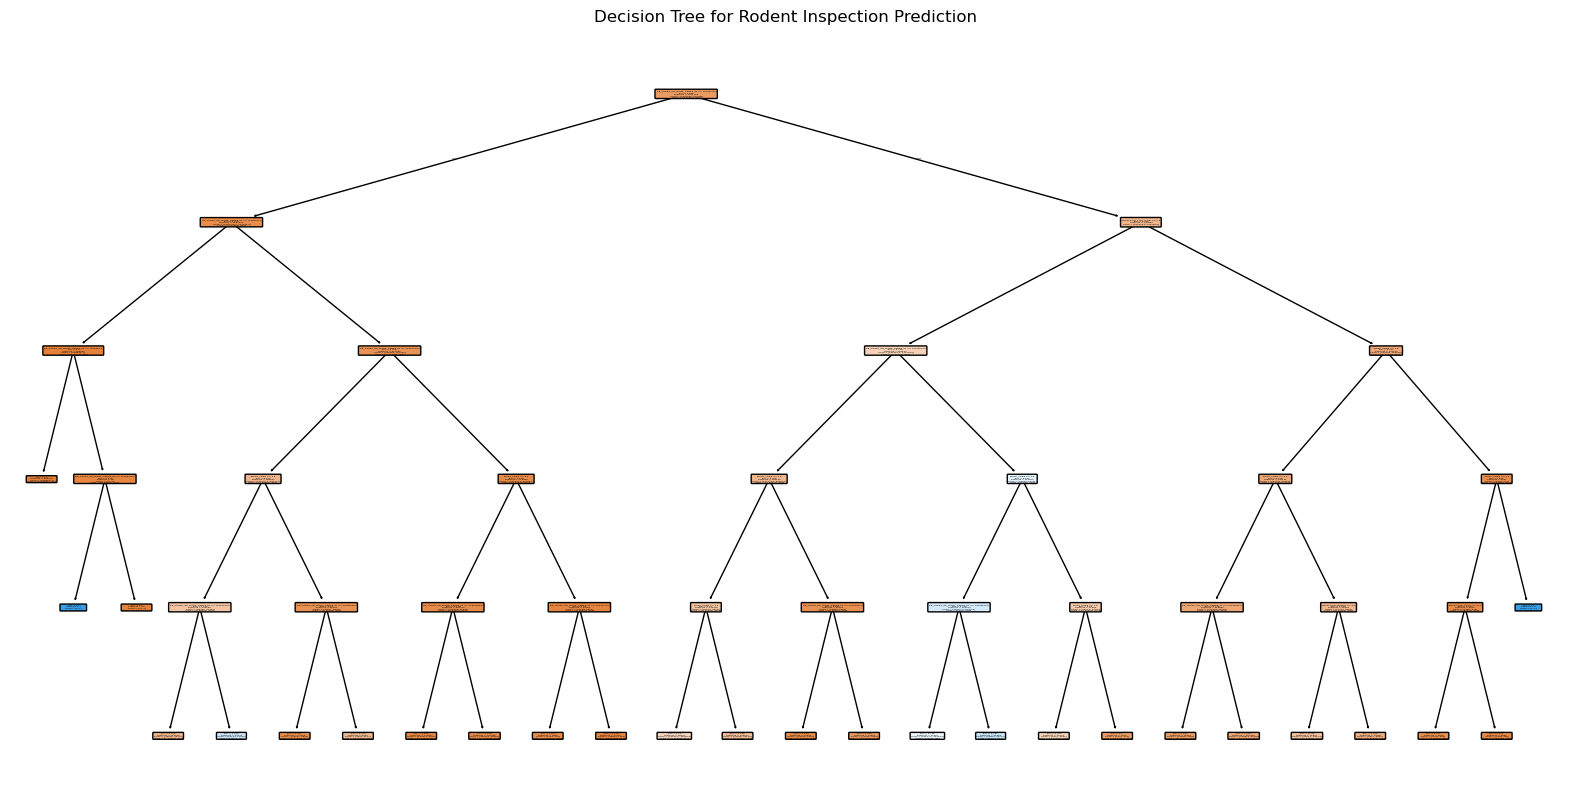

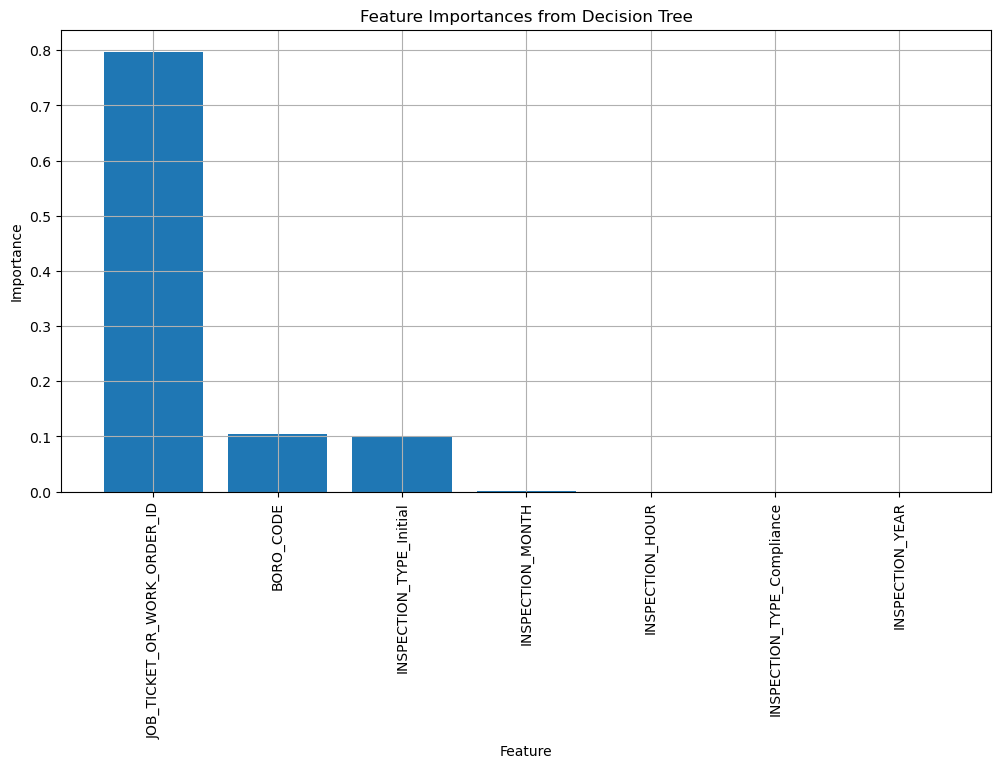

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

columns_to_keep = [
    'INSPECTION_TYPE', 'JOB_TICKET_OR_WORK_ORDER_ID', 'BORO_CODE',
    'INSPECTION_DATE', 'RESULT'
]

dtype_spec = {
    'INSPECTION_TYPE': str,
    'JOB_TICKET_OR_WORK_ORDER_ID': str,
    'BORO_CODE': float,
    'INSPECTION_DATE': str,
    'RESULT': str
}

# important columns
df = pd.read_csv(
    '/Users/sindhugadiraju/Downloads/Rodent_Inspection_20250410.csv',
    usecols=columns_to_keep,
    dtype=dtype_spec
)

print(df.head())

# drop rows with missing values
df = df.dropna(subset=columns_to_keep)

# parse INSPECTION_DATE exactly
df['INSPECTION_DATE'] = pd.to_datetime(
    df['INSPECTION_DATE'],
    format='%m/%d/%Y %I:%M:%S %p',
    errors='coerce'
)

# drop rows with invalid dates
df = df.dropna(subset=['INSPECTION_DATE'])

# filter years after 2009
df = df[df['INSPECTION_DATE'].dt.year >= 2010]

print(f" After cleaning, {df.shape[0]} rows remain.")


df['INSPECTION_MONTH'] = df['INSPECTION_DATE'].dt.month
df['INSPECTION_YEAR'] = df['INSPECTION_DATE'].dt.year
df['INSPECTION_HOUR'] = df['INSPECTION_DATE'].dt.hour

# encode inspection type
df_encoded = pd.get_dummies(df[['INSPECTION_TYPE']], drop_first=True)

# define feautures and target

X = pd.concat([
    df[['JOB_TICKET_OR_WORK_ORDER_ID', 'BORO_CODE', 'INSPECTION_MONTH', 'INSPECTION_YEAR', 'INSPECTION_HOUR']],
    df_encoded
], axis=1)

rodent_positive_labels = ['Active Rat Signs', 'Rat Activity', 'Bait Applied', 'Bait Replenished']

y = df['RESULT'].isin(rodent_positive_labels).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# decision tree
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

# predict
y_pred = tree.predict(X_test)

# evaluation
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred, labels=[0, 1]))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Rodent Issue', 'Rodent Issue']))

print(f"\nAccuracy Score: {accuracy_score(y_test, y_pred):.4f}")

plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X.columns, class_names=['No Rodent Issue', 'Rodent Issue'], filled=True, rounded=True)
plt.title('Decision Tree for Rodent Inspection Prediction')
plt.show()

# 14. Feature Importance
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances from Decision Tree")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.grid()
plt.show()

# accuracy vs depth
train_accuracies, test_accuracies = [], []
depths = range(1, 20)
for d in depths:
    temp_tree = DecisionTreeClassifier(max_depth=d, random_state=42)
    temp_tree.fit(X_train, y_train)
    train_accuracies.append(temp_tree.score(X_train, y_train))
    test_accuracies.append(temp_tree.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, label="Train")
plt.plot(depths, test_accuracies, label="Test")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Tree Depth")
plt.legend()
plt.grid()
plt.show()


Feature importance bar chart:

JOB_TICKET_OR_WORK_ORDER_ID dominated with a weight of ~0.8 — but this is problematic.

Warning: This ID is likely just a unique identifier and not semantically meaningful. Its high importance might indicate data leakage or overfitting to noise.

Other features like BORO_CODE and INSPECTION_TYPE_Initial had minor but real contributions.

✅ Suggestion: Consider removing JOB_TICKET_OR_WORK_ORDER_ID from the model and retraining to avoid learning from an ID field.